In [2]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn

## Load and create datasets

In [3]:
from keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()
X_train, X_valid, X_finetune = X_train[10_000:], X_train[:5000], X_train[5000:10_000]
y_train, y_valid, y_finetune = y_train[10_000:], y_train[:5000], y_train[5000:10_000]

print(f"""X_train: {X_train.shape}, y_train: {y_train.shape},
X_valid: {X_valid.shape}, y_valid: {y_valid.shape},
X_finetune: {X_finetune.shape}, y_finetune: {y_finetune.shape},
X_test: {X_test.shape}, y_test: {y_test.shape} """)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train: (50000, 28, 28), y_train: (50000,),
X_valid: (5000, 28, 28), y_valid: (5000,),
X_finetune: (5000, 28, 28), y_finetune: (5000,),
X_test: (10000, 28, 28), y_test: (10000,) 


## Save datasets

In [4]:
number = int(input('enter number: '))
with open(f'finetune_images{number}.npy', 'wb') as f:
  np.save(f, X_finetune)
with open(f'finetune_labels{number}.npy', 'wb') as f:
  np.save(f, y_finetune)
with open(f'test_images{number}.npy', 'wb') as f:
  np.save(f, X_test)
with open(f'test_labels{number}.npy', 'wb') as f:
  np.save(f, y_test)
with open(f'valid_images{number}.npy', 'wb') as f:
  np.save(f, X_valid)
with open(f'valid_labels{number}.npy', 'wb') as f:
  np.save(f, y_valid)

enter number:  7


## Data augmentations

In [5]:
from scipy.ndimage.interpolation import shift, rotate, zoom
from scipy.ndimage import gaussian_filter
def shift_image(image, low = -7, high = 7):
    """
    This function shifts an image along x and y based on two random shift values.
    """
    dy = np.random.randint(low, high)
    while dy == 0:
        dy = np.random.randint(low, high)
    dx = np.random.randint(low, high)
    while dx == 0:
        dx = np.random.randint(low, high)
    return shift(image, [dy, dx])

def rotate_image(image, low = -45, high = 45):
    """
    This function rotates and returns an image.
    """
    angle = np.random.randint(low, high)
    while angle >= -5 and angle <= 5:
        angle = np.random.randint(low, high)
    return rotate(image, angle, reshape = False)

def zoom_in_out(image, ratio = (1.2, 0.7)):
    """
    This function randomly zooms in or out an image and then returns that image.
    """
    random_choice = np.random.randint(0, 2)
    if random_choice == 0:
        zoomed_image = zoom(image, ratio[0])
        zoomed_image = np.delete(zoomed_image, [i for i in range (zoomed_image.shape[0] - 28)], 0)
        zoomed_image = np.delete(zoomed_image, [i for i in range (zoomed_image.shape[1] - 28)], 1)
    elif random_choice == 1:
        zoomed_image = zoom(image, ratio[1])
        zoomed_image = np.append(zoomed_image, np.zeros((zoomed_image.shape[0], 28 - zoomed_image.shape[1])), axis = 1)
        zoomed_image = np.append(zoomed_image, np.zeros((28 - zoomed_image.shape[0], zoomed_image.shape[1])), axis = 0)
    return zoomed_image

def blur(image, sigma = 1):
    """
    Blurs a given image.
    """
    return gaussian_filter(image, sigma)

/tmp/ipykernel_34/3879369607.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift, rotate, zoom
/tmp/ipykernel_34/3879369607.py:1: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift, rotate, zoom
/tmp/ipykernel_34/3879369607.py:1: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift, rotate, zoom


In [6]:
def augment_dataset(original_dataset):
  """Randomly selects one augmentation technique and applies this to the image
  """
  np.random.shuffle(original_dataset)
  augmented_dataset = original_dataset.copy()
  num_of_augmentations = 4
  aug_functions = [
      shift_image, rotate_image, zoom_in_out, blur
  ]
  for i in range(augmented_dataset.shape[0]):
    chosen_aug = random.choice(aug_functions)
    augmented_dataset[i] = chosen_aug(augmented_dataset[i])

  dataset = np.concatenate((original_dataset.reshape((-1, 1, 28*28)), augmented_dataset.reshape((-1, 1, 28*28))), axis=1)

  return dataset

## Build the model

In [7]:
def create_model():
    inputs = keras.layers.Input(shape=(28*28,))
    layer1 = keras.layers.Dense(500, activation='selu',
                                kernel_initializer = 'glorot_uniform' , kernel_regularizer = tf.keras.regularizers.L2(0.1))(inputs)
    layer2 = keras.layers.Dense(400, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer1)
    layer3 = keras.layers.Dense(300, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer2)
    layer4 = keras.layers.Dense(200, activation='selu',
                                kernel_initializer = 'glorot_uniform', kernel_regularizer = tf.keras.regularizers.L2(0.1))(layer3)
    model = keras.models.Model(inputs=inputs, outputs=[layer1, layer2, layer3, layer4])
    return model

model = create_model()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       120,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        60,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773,400 (2.95 MB)

 Trainable params: 773,400 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

## VICReg loss

In [8]:
def vicreg_loss(z_a, z_b, var_weight = 25, inv_weight = 25, cov_weight = 1):
  # variance loss
  variance_loss_epsilon = 1e-5
  std_z_a = tf.sqrt(tf.math.reduce_variance(z_a, axis=0) + variance_loss_epsilon)
  std_z_b = tf.sqrt(tf.math.reduce_variance(z_b, axis=0) + variance_loss_epsilon)
  loss_v_a = tf.reduce_mean(tf.nn.relu(1 - std_z_a))
  loss_v_b = tf.reduce_mean(tf.nn.relu(1 - std_z_b))
  loss_var = loss_v_a + loss_v_b

  # invariance loss|
  loss_inv = tf.reduce_mean(tf.reduce_sum(tf.square(z_a - z_b), axis = 1))

  #covariance loss
  N, D = z_a.shape
  z_a = z_a - tf.reduce_mean(z_a, axis=0)
  z_b = z_b - tf.reduce_mean(z_b, axis=0)
  cov_z_a = tf.square(tf.matmul(tf.transpose(z_a), z_a) / (N - 1))
  cov_z_b = tf.square(tf.matmul(tf.transpose(z_b), z_b) / (N - 1))
  loss_c_a = (tf.reduce_sum(cov_z_a)- tf.reduce_sum(tf.linalg.diag_part(cov_z_a))) / D
  loss_c_b = (tf.reduce_sum(cov_z_b)- tf.reduce_sum(tf.linalg.diag_part(cov_z_b))) / D
  loss_cov = loss_c_a + loss_c_b

  #total weighted loss
  total_loss = (var_weight * loss_var) + (inv_weight * loss_inv) + (cov_weight * loss_cov)
  return total_loss

In [9]:
layer1 = model.layers[1]
layer2 = model.layers[2]
layer3 = model.layers[3]
layer4 = model.layers[4]

layers = [layer1, layer2, layer3, layer4]

learning_rate_layer1 = 0.01
learning_rate_layer2 = 0.001
learning_rate_layer3 = 0.0001
learning_rate_layer4 = 0.00001

optimizer_layer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer1)
optimizer_layer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer2)
optimizer_layer3 = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer3)
optimizer_layer4 = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer4)

optimizers = [optimizer_layer1, optimizer_layer2, optimizer_layer3, optimizer_layer4]

var_weights = [25, 25, 25, 25]
inv_weights = [25, 25, 25, 25]
cov_weights = [1, 1, 1, 1]

## Visualization

In [10]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
def plot_figure(model, epoch, plot_list):
  tsne = TSNE()
  data_2D = tsne.fit_transform(model(X_test.reshape((-1, 28*28)))[2])
  data_viz = np.concatenate((data_2D, y_test.reshape(len(y_test), 1)), axis = 1)
  data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])
  plt.figure(figsize = (15, 10))
  sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
  plt.title(f"Epoch:{epoch+1}",fontsize=16, fontweight='bold')
  plt.xlabel('Dimension 1', fontsize=14, weight = 'bold')
  plt.ylabel('Dimension 2', fontsize=14, weight = 'bold')
  plt.savefig(f"plot{epoch}.png")
  plot_list.append(f"plot{epoch}.png")
  plt.show()

## Training loop

In [11]:
epochs = 50
plot_list = []
losses1, losses2, losses3, losses4 = [], [], [], []
losses = [losses1, losses2, losses3, losses4]
dv_index1, dv_index2, dv_index3, dv_index4 = [], [], [], []

for epoch in range(epochs):
  dataset = augment_dataset(X_train)
  dataset = dataset.astype('float32') / 255
  dataset = tf.data.Dataset.from_tensor_slices((dataset))

  BATCH_SIZE = 2048
  SHUFFLE_BUFFER_SIZE = 25000
  dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

  iteration1, iteration2, iteration3, iteration4 = 0, 0, 0, 0
  loss1, loss2,loss3, loss4 = 0., 0., 0., 0.
  for batch in dataset:
    x = batch[:, 0, :]
    y = batch[:, 1, :]
    for layer, optimizer, var, inv, cov, loss_ in zip(layers, optimizers, var_weights, inv_weights, cov_weights, losses):

      #TRAINING LAYER 1
      if layer == layers[0]:
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss1 += loss
        iteration1 += 1

      #TRAINING LAYER 2
      if layer == layers[1]:
        x = layers[0](batch[:, 0, :])
        y = layers[0](batch[:, 1, :])
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss2 += loss
        iteration2 += 1

      #TRAINING LAYER 3
      if layer == layers[2]:
        x = layers[1](layers[0](batch[:, 0, :]))
        y = layers[1](layers[0](batch[:, 1, :]))
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss3 += loss
        iteration3 += 1

      #TRAINING LAYER 4
      if layer == layers[3]:
        x = layers[2](layers[1](layers[0](batch[:, 0, :])))
        y = layers[2](layers[1](layers[0](batch[:, 1, :])))
        with tf.GradientTape() as tape:
          x = layer(x)
          y = layer(y)
          loss = vicreg_loss(x, y, var , inv , cov )
        gradients = tape.gradient(loss, layer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
        loss4 += loss
        iteration4 += 1

  dv_index1.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 28*28)))[0], y_valid))
  dv_index2.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 28*28)))[1], y_valid))
  dv_index3.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 28*28)))[2], y_valid))
  dv_index4.append(sklearn.metrics.davies_bouldin_score(model(X_valid.reshape((-1, 28*28)))[3], y_valid))

  print(f"""
  Layer 1 DV Index: {dv_index1[-1]},
  Layer 2 DV Index: {dv_index2[-1]},
  Layer 3 DV Index: {dv_index3[-1]},
  Layer 4 DV Index: {dv_index4[-1]}
  """)

  losses1.append(loss1 / 25.)
  losses2.append(loss2 / 25.)
  losses3.append(loss3 / 25.)
  losses4.append(loss4 / 25.)

  #if epoch % 5 == 0:
  #  plot_list.append(plot_figure(model, epoch, plot_list))
  #elif epoch == epochs - 1:
  #  plot_list.append(plot_figure(model, epoch, plot_list))
  print(f'Epoch {epoch} ends here.')

  learning_rate_layer1 = 0.01*0.1**(epoch/50)
  learning_rate_layer2 = 0.001*0.1**(epoch/50)
  learning_rate_layer3 = 0.0001*0.1**(epoch/50)
  learning_rate_layer4 = 0.00001*0.1**(epoch/50)
  optimizers[0] = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer1)
  optimizers[1] = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer2)
  optimizers[2] = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer3)
  optimizers[3] = tf.keras.optimizers.Adam(learning_rate=learning_rate_layer4)

  print("===========================================================================================================================================")
  dataset = dataset.unbatch()


  Layer 1 DV Index: 5.36718503746148,
  Layer 2 DV Index: 6.328940046416868,
  Layer 3 DV Index: 6.6194265012678954,
  Layer 4 DV Index: 7.3317125118712925
  
Epoch 0 ends here.

  Layer 1 DV Index: 4.087923410069784,
  Layer 2 DV Index: 4.565252243813073,
  Layer 3 DV Index: 4.787857650137712,
  Layer 4 DV Index: 4.997032954559355
  
Epoch 1 ends here.

  Layer 1 DV Index: 4.121893099421063,
  Layer 2 DV Index: 4.5852299198152435,
  Layer 3 DV Index: 4.928223433033666,
  Layer 4 DV Index: 5.1497611774487035
  
Epoch 2 ends here.

  Layer 1 DV Index: 4.29281652222372,
  Layer 2 DV Index: 4.667880247197195,
  Layer 3 DV Index: 5.00302994013108,
  Layer 4 DV Index: 5.134280171387049
  
Epoch 3 ends here.

  Layer 1 DV Index: 4.070660374115575,
  Layer 2 DV Index: 4.52704053396343,
  Layer 3 DV Index: 4.756126258049443,
  Layer 4 DV Index: 5.068603985587023
  
Epoch 4 ends here.

  Layer 1 DV Index: 4.143393697881868,
  Layer 2 DV Index: 4.626127587182499,
  Layer 3 DV Index: 4.914711450

## Evaluation

In [13]:
print(f"""
LAYER 1: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 28*28)))[0], y_test)},
LAYER 2: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 28*28)))[1], y_test)},
LAYER 3: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 28*28)))[2], y_test)},
LAYER 4: {sklearn.metrics.davies_bouldin_score(model(X_test.reshape((-1, 28*28)))[3], y_test)}
      """)


LAYER 1: 3.3602059421551744,
LAYER 2: 3.339500432129065,
LAYER 3: 3.287259618321926,
LAYER 4: 3.264590537007578
      


In [14]:
print(f"""
LAYER 1: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 28*28)))[0], y_test)},
LAYER 2: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 28*28)))[1], y_test)},
LAYER 3: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 28*28)))[2], y_test)},
LAYER 4: {sklearn.metrics.calinski_harabasz_score(model(X_test.reshape((-1, 28*28)))[3], y_test)}
      """)


LAYER 1: 532.2892252292357,
LAYER 2: 565.6909245198191,
LAYER 3: 592.7283840073932,
LAYER 4: 533.8002292893256
      


In [15]:
print(f"""
LAYER 1: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 28*28)))[0], y_test)},
LAYER 2: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 28*28)))[1], y_test)},
LAYER 3: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 28*28)))[2], y_test)},
LAYER 4: {sklearn.metrics.silhouette_score(model(X_test.reshape((-1, 28*28)))[3], y_test)}
      """)


LAYER 1: 0.04380670189857483,
LAYER 2: 0.04670277237892151,
LAYER 3: 0.049878861755132675,
LAYER 4: 0.05013594403862953
      


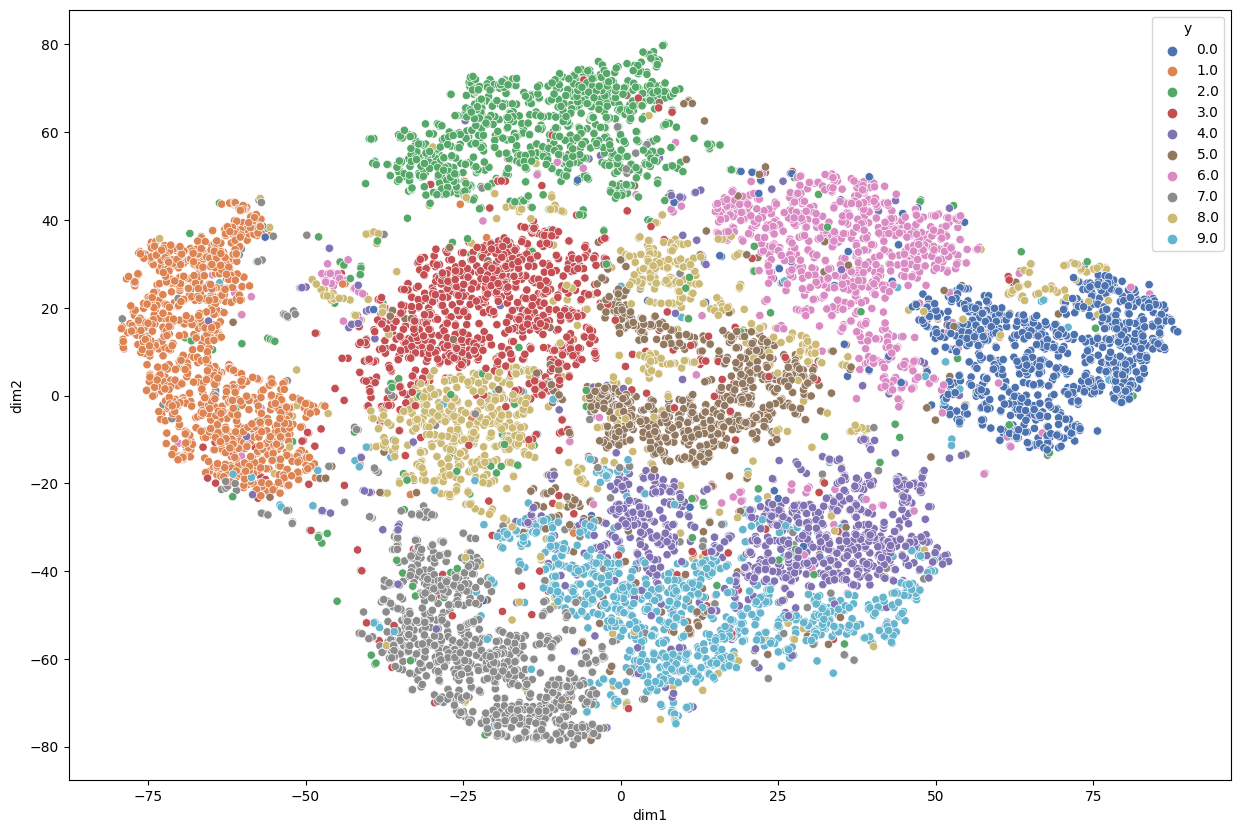

In [16]:
tsne = TSNE()
data_2D = tsne.fit_transform(model(X_test.reshape((-1, 28*28)))[-1])
data_viz = np.concatenate((data_2D, y_test.reshape(len(y_test), 1)), axis = 1)
data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])
plt.figure(figsize = (15, 10))
sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
plt.show()

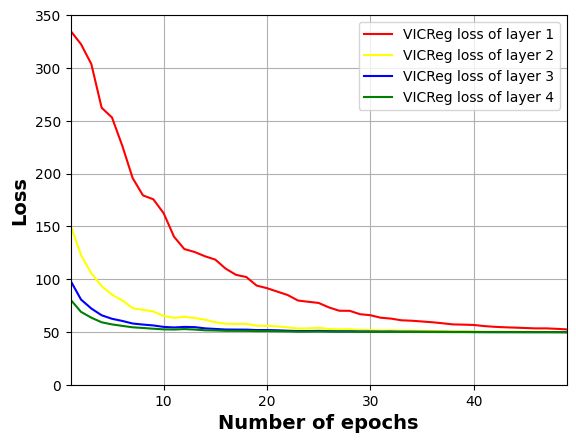

In [28]:
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses1]), label = "VICReg loss of layer 1", color = 'red')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses2]), label = "VICReg loss of layer 2", color = 'yellow')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses3]), label = "VICReg loss of layer 3", color = 'blue')
plt.plot(np.arange(0,50), np.array([l.numpy() for l in losses4]), label = "VICReg loss of layer 4", color = 'green')
plt.xlabel('Number of epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlim(1, 49)
plt.ylim(0, 350)
plt.grid(True)
plt.legend()
plt.show()

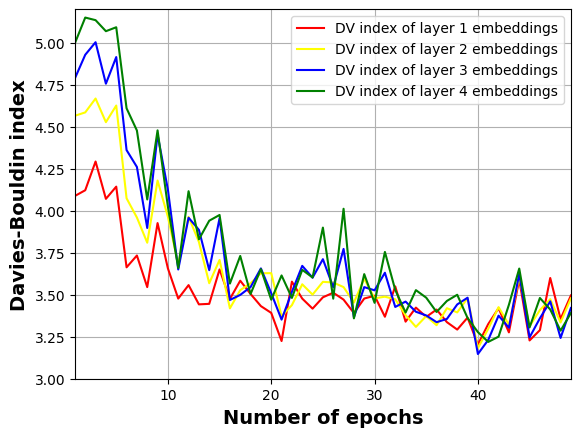

In [25]:
plt.plot(np.arange(0,50), np.array(dv_index1), label = "DV index of layer 1 embeddings", color = 'red')
plt.plot(np.arange(0,50), np.array(dv_index2), label = "DV index of layer 2 embeddings", color = 'yellow')
plt.plot(np.arange(0,50), np.array(dv_index3), label = "DV index of layer 3 embeddings", color = 'blue')
plt.plot(np.arange(0,50), np.array(dv_index4), label = "DV index of layer 4 embeddings", color = 'green')
plt.xlabel('Number of epochs', fontsize=14, fontweight='bold')
plt.ylabel('Davies-Bouldin index', fontsize=14, fontweight='bold')
plt.xlim(1, 49)
plt.ylim(3, 5.2)
plt.grid(True)
plt.legend()
plt.show()

In [26]:
model.save('model.keras')
model.save('model.h5')